# Spectral Clustering

## Author : Vincent HERFELD


In this exercise, you will implement spectral clustering and try it on diffent kinds of data, for instance:

* N-blob: Random points in $\mathbb{R}^2$ according to N Gaussian distributions with different means;

* Two moons: Random points shaped as two intertwined moons; 

* Point and circle: random points from a concentrated Gaussian point in the middle and a wide circle around it.

The first step after generating the data is to construct a graph and, for that, we need a similarity function. In this exercise we will use the following similarity:

$$
d(x_i, x_j) = \exp\left(-\frac{||x_i-x_j||_2^2}{2\sigma^2}\right)
$$

Using this similarity, we can compute the weight matrix W representing the graph, compute the graph Laplacian L and finally use its eigenvectors for clustering.


## Setup

In [18]:
from generate_data import worst_case_blob, blobs, two_moons, point_and_circle
from utils import plot_clusters, min_span_tree, plot_graph_matrix, min_span_tree
from utils import plot_clustering_result, plot_the_bend
from sklearn.cluster import KMeans
import sklearn.metrics as skm
import numpy as np
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import os

In [19]:
def plot_eig(w):
    plt.figure()
    plt.title("Eigenvalues : smoothness of assossiated eigenvectors")
    plt.plot(w)
    plt.show()

## Generating the data

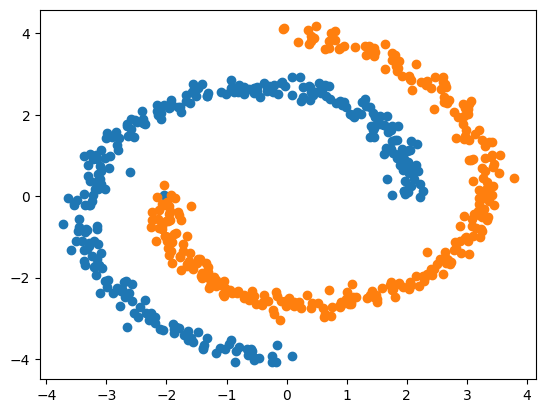

Signature: worst_case_blob(num_samples, delta=5)
Docstring:
Generates a single blob.

:param num_samples: number of samples to create in the blob
:param delta:
:return: X,  (num_samples, 2) matrix of 2-dimensional samples
         Y,  (num_samples, ) vector of "true" cluster assignment
File:      ~/Desktop/Cours/MVA/S2/GraphML/TP/spectral_clustering/generate_data.py
Type:      function

In [20]:
# Example

for fn in [two_moons]:  #  try also [worst_case_blob, point_and_circle, blobs]
    X, Y = fn(num_samples=600)
    plot_clusters(X, Y, fignum=str(fn))

# You can check the documentation of each function to see the optional parameters, e.g.:
worst_case_blob?

## Building similarity graph

In [21]:
def build_similarity_graph(X, var=1.0, eps=0.0, k=0):
    """
    TO BE COMPLETED.

    Computes the similarity matrix for a given dataset of samples. 
    If k=0, builds epsilon graph. 
    Otherwise, builds kNN graph.

    Parameters
    ----------
    X : numpy array
        (n x m) matrix of m-dimensional samples
    var : double 
        the sigma value for the exponential function, already squared
    eps : double
        threshold for epsilon graphs
    k : int
        The number of neighbours k for k-nn. If zero, use epsilon-graph

    Returns
    -------
        W: (n x n) dimensional matrix representing the weight matrix of the graph
    """
    n = X.shape[0]
    W = np.zeros((n, n))

    """
    Build similarity graph, before threshold or kNN
    similarities: (n x n) matrix with similarities between all possible couples of points.
    The similarity function is d(x,y)=exp(-||x-y||^2/(2*var))
    """
  
    similarities = np.exp(-skm.pairwise.euclidean_distances(X, X)**2 / (2 * var))
    
    # If epsilon graph
    if k == 0:
        """
        compute an epsilon graph from the similarities             
        for each node x_i, an epsilon graph has weights             
        w_ij = d(x_i,x_j) when w_ij >= eps, and 0 otherwise          
        """
        W[similarities >= eps] = similarities[similarities >= eps]

    # If kNN graph
    elif k != 0:
        """
        compute a k-nn graph from the similarities                   
        for each node x_i, a k-nn graph has weights                  
        w_ij = d(x_i,x_j) for the k closest nodes to x_i, and 0     
        for all the k-n remaining nodes                              
        Remember to remove self similarity and                       
        make the graph undirected                                    
        """
        
        indices = np.argsort(similarities, axis=1) #build matrix of indices with sorted similarities in decreasing order
        for i in range(n):
            for idx in indices[i, -k-1:-1]:
                W[i, idx] = similarities[i, idx]
                W[idx, i] = W[i, idx]  #make undirected graph
    np.fill_diagonal(W, 0) #remove self similarities
    return W


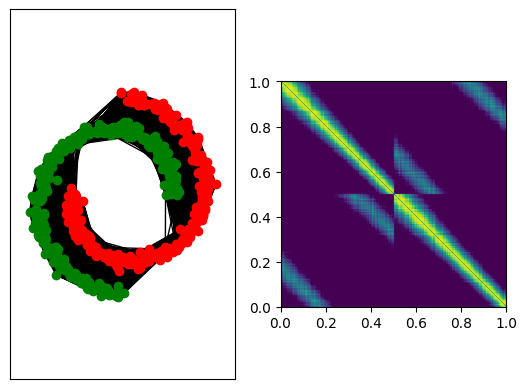

In [22]:
# Example

W = build_similarity_graph(X, eps = 0.1)
W[0, 599] = 1    # add two placeholder edges to reproduce example picture
W[10, 500] = 1   # 


plot_graph_matrix(X, Y, W)  # shows the graph and the visualization of W

## Computing the Laplacian

In [23]:
def build_laplacian(W, laplacian_normalization='unn'):
    """
    Compute graph Laplacian.

    Parameters
    ----------
    W : numpy array
        Adjacency matrix (n x n)
    laplacian_normalization : str
        String selecting which version of the laplacian matrix to construct.
            'unn':  unnormalized,
            'sym': symmetric normalization
            'rw':  random-walk normalization   

    Returns
    -------
    L: (n x n) dimensional matrix representing the Laplacian of the graph
    """
    D = np.diag(W.sum(axis=1))
    
    L = D - W #unnormalized
    
    if laplacian_normalization == 'sym':
        L = np.linalg.inv(D)**(.5) @ L @ np.linalg.inv(D)**(.5) #this works since D is diagonal by construction
    elif laplacian_normalization == 'rw':
        L = np.linalg.inv(D) @ L
    elif laplacian_normalization != 'unn':
        print("Unkown normalization scheme")
        return 1
    
    return L

## Clustering

In [92]:
import scipy
from scipy.signal import find_peaks

def spectral_clustering(L, chosen_eig_indices=None, num_classes=2):
    """
    Parameters
    ----------
    L : numpy array
        Graph Laplacian (standard or normalized)
    choosen_eig_indices : list or None
        Indices of eigenvectors to use for clustering. 
        If None, use adaptive choice of eigenvectors.
    num_classes : int 
        Number of clusters to compute (defaults to 2)


    Returns
    -------
    Y : numpy array (num_samples, )
        Cluster assignments
    """

    """
    Use the function scipy.linalg.eig or the function scipy.sparse.linalg.eigs to compute:
    U = (n x n) eigenvector matrix           (sorted)
    E = (n x n) eigenvalue diagonal matrix   (sorted)
    """
    w, U = scipy.linalg.eig(L)
    
    
    sorted_indices = np.argsort(w)[::1]
    w = np.real(w[sorted_indices])
    
    U = np.real(U[:, sorted_indices])
    E = np.diag(w)

    
    Y = np.zeros(L.shape[0])
    if chosen_eig_indices:
        eigs = U[:, chosen_eig_indices]
    else:
        if num_classes==None:
            eigengap = np.max(np.diff(w))
            num_classes = np.argmax(np.diff(w)[:len(w)//2]) + 1
        eigs = np.empty((U.shape[0], num_classes))
        k = 0
        for i,e in enumerate(U.T[1:]): #skip the first constant eigenvector then check for others only keep non constant.
            if ~np.all(e == e[0]):
                eigs[:,i] = e
                k += 1
                if k == num_classes:
                    break
        print(f"{k} eigenvectors were chosen")
                    
    kmeans = KMeans(n_clusters=num_classes, n_init=10).fit(eigs)
    Y = kmeans.labels_
    
    return Y, w

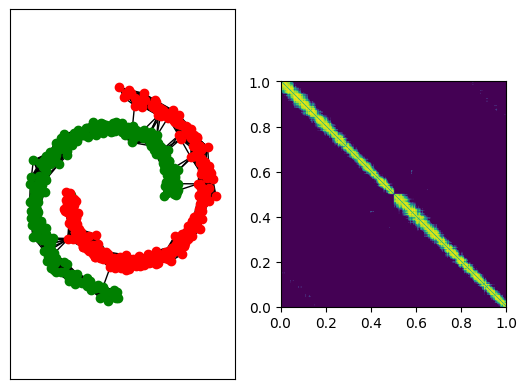

In [10]:
W = build_similarity_graph(X, eps=0.7) 

plot_graph_matrix(X, Y, W)  # shows the graph and the visualization of W

The graph is connected.

(600,)


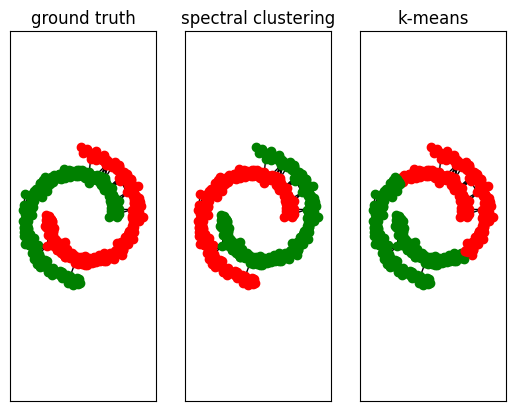

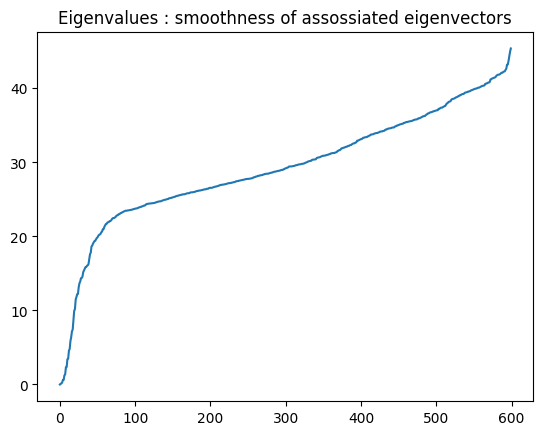

In [11]:
# Example

num_classes = 2

L = build_laplacian(W, 'unn')
Y_rec, w = spectral_clustering(L, chosen_eig_indices=[1,2], num_classes=num_classes)

print(Y_rec.shape)

#print(Y_rec)
# Plot results, comparing to KMeans
plot_clustering_result(X, Y, W, Y_rec, KMeans(num_classes, n_init=10).fit_predict(X))
plot_eig(w)

# Questions

### Q1.1: What is the purpose of the option parameter in `worst_case_blob`?

There is a an optional parameter "delta" in worst_case_blob which determines how far the outlying "splash" is from the main blob. We shall plot different instances of worst_case_blob with varying delta value.

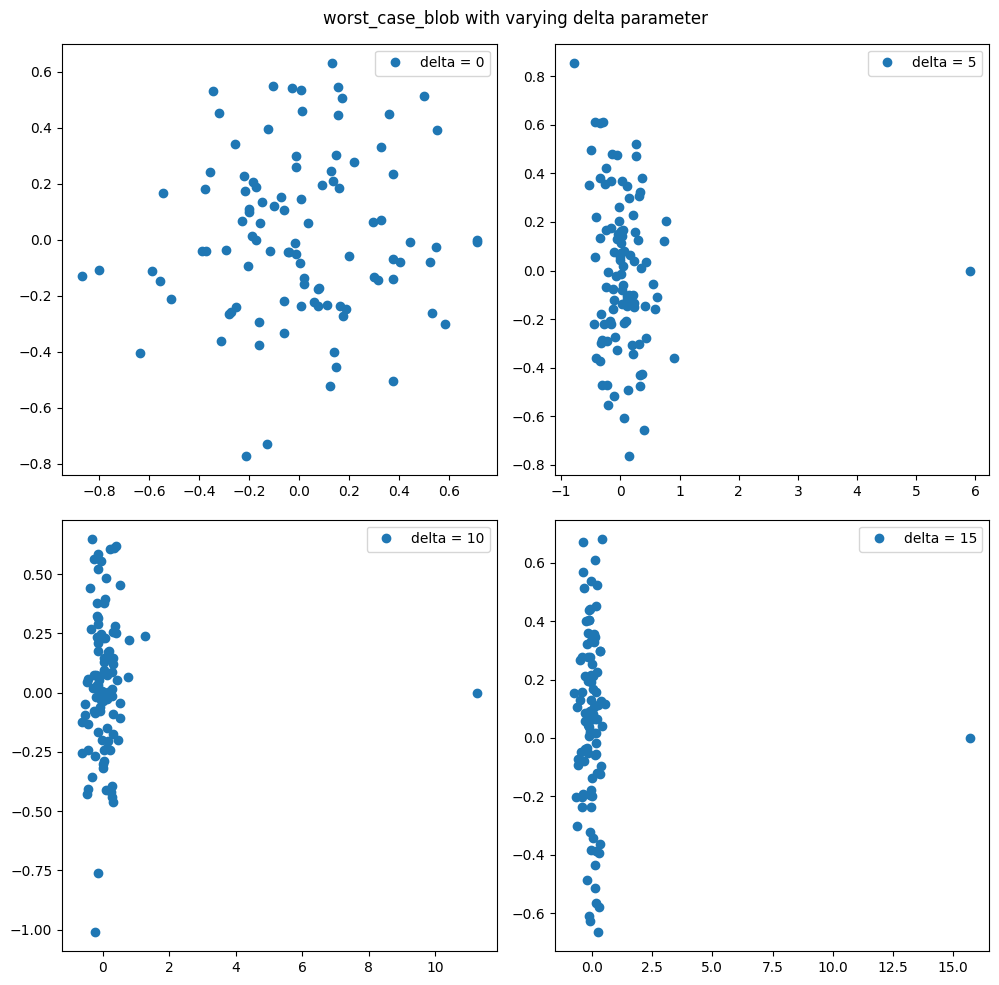

In [12]:
Delta = [0, 5, 10, 15]

fig, axs = plt.subplots(len(Delta) // 2, len(Delta) // 2, figsize = (10, 10))
plt.suptitle("worst_case_blob with varying delta parameter")
plt.tight_layout()

axs = axs.flatten()

for delta, ax in zip(Delta, axs):  #  try also [worst_case_blob, point_and_circle, blobs]
    X, Y = worst_case_blob(num_samples=100, delta = delta)
    
    K = Y.max() + 1
    for k in range(K):
        ax.plot(X[Y == k, 0], X[Y == k, 1], 'o', label=f"delta = {delta}")
    
    ax.legend()

It does not modify a lot the variance in the main blob indeed when plotting at equal scale we observe that only the distance changes :

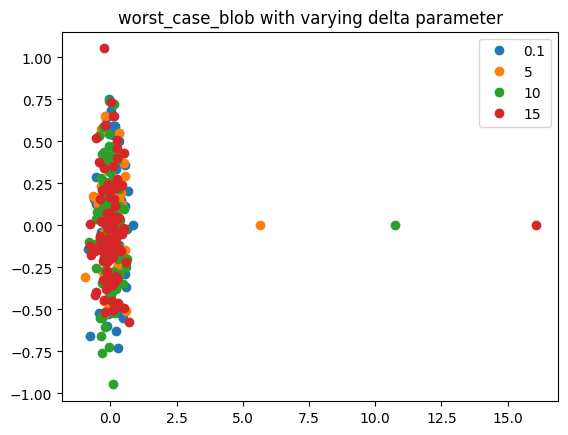

In [11]:
Delta = [0.1, 5, 10, 15]


for delta, ax in zip(Delta, axs):  #  try also [worst_case_blob, point_and_circle, blobs]
    X, Y = worst_case_blob(num_samples=100, delta = delta)
    plot_clusters(X, Y, fignum=str(fn))
    
plt.title("worst_case_blob with varying delta parameter")
plt.legend(Delta)

### Q1.2: While varying the parameter of `worst_case_blob`, try to select a value of $\epsilon$ that keeps the graph connected (the function `min_span_tree` can help you). What happens? Can you tell when it is a bad idea to use this approach?

What we can do is connect fully the graph by using $\epsilon = 0$ and then computing the minimal spanning tree to make sure that we don't overdo the connection. This could be interesting in some cases but it completely looses sens of similarity, and when delta is high just connects all nodes to the outlier. When all nodes are connected to the outlier, then the outlier won't be isolated in its own class and won't be detected as an outlier, in `worst_case_blob` there is only one class so it is not a problem, but when we want to seperate the outlier it can become one. Also the min span tree causes the weight matrix to be singular so we cannot use matrix inversion such it is the case for sym and rw matrices.

So here connecting the outlier is good, but this means that we know there is only one class which is not interesting in practice why cluster when we know everything is together in the same class. Any algorithm would work.

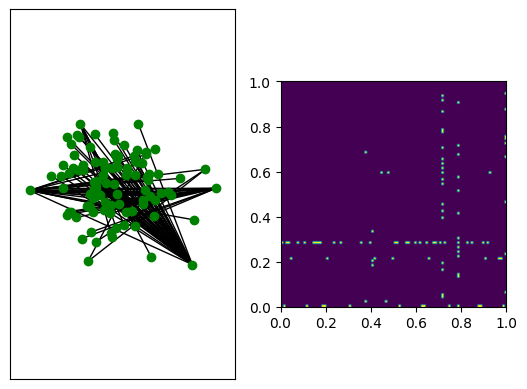

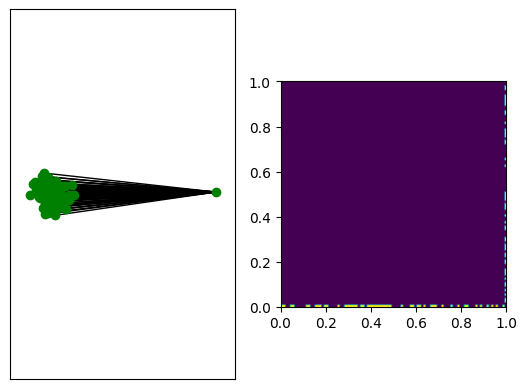

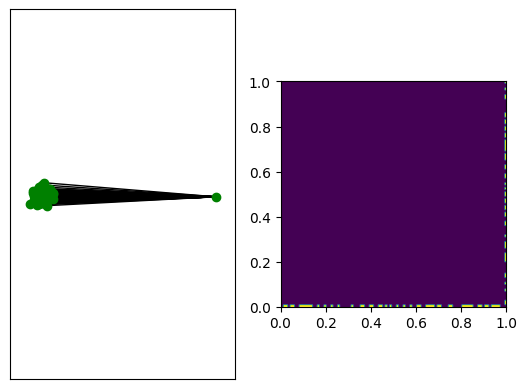

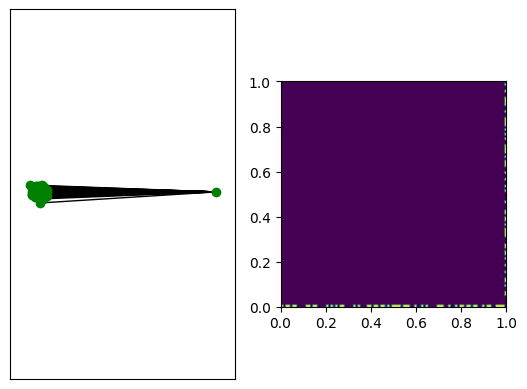

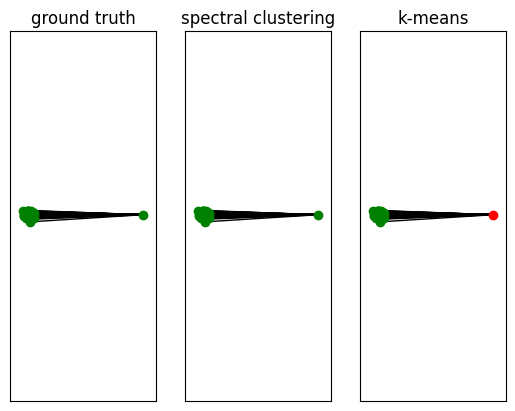

In [12]:
#min_span_tree?
num_classes = 2
var = 10.0

for delta in Delta:
    X, Y = worst_case_blob(num_samples=100, delta = delta)
    W = build_similarity_graph(X, var=var, eps = 0)
    T = min_span_tree(W)
    plot_graph_matrix(X, Y, T)  # shows the graph and the visualization of W

L = build_laplacian(T, 'unn')
Y_rec,w = spectral_clustering(L, chosen_eig_indices=[0], num_classes=num_classes)

#print(Y_rec)
# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes, n_init=10).fit_predict(X))

### Q1.3: Is it important to build a connected graph? Compare k-NN to $\epsilon$-graphs with respect to the difficulty of building a connected graph.

When constructing a graph we must make sure to avoid adding bias to our construction. When a graph is not connected it will bias clustering algorithms in thinking that the connected components should stay isolated, this could be a wrong assumption for our data especially in high dimensional spaces that are not visually understandable.

When thinking about constructing a connected graph we can choose between k-NN and $\epsilon$-graphs. On one hand a k-NN graph makes sure that each node is at least of degree k meaning that it is easy to make sure that every node is connected to others (this does not ensure that the graph is a connected graph !) there can be moments where in high density zones nodes all connect to each other as closest neighbours and neglect nodes that are further away, we thus must augment k to be larger than the number of nodes that are in the dense area. On the other hand, $\epsilon$-graphs will connect nodes to as many others as possible given that they are more similar than $\epsilon$, so diminishing epsilon will eventually (and it seems easier) connect the graph. Also $\epsilon$ is bounded in $]0, 1]$. That said $\epsilon-$graph is dependant on the scale of the distances/similarites in the graph, the value of $\epsilon$ that works well is very dependent on the data more than k-nn is. 

So finally fully connecting a graph is not "hard" since we can just go and choose absurd values like $\epsilon = 0$ or $k = n-1$ such that every node is connected, but this is not very interesting in some cases, so choosing that right graph is difficult.

Another way is like it was done in the Example is when we can visualise the data, we can deduce that using one type of graph will connect different components we then can manually add edges to ensure connectivity.

### Q2.1: Build a graph starting from the data generated in `blobs`, and keep the graph connected. Use `spectral_clustering` to cluster the data. Motivate your choice on which eigenvectors to use and how you computed the clustering assignments from the eigenvectors. Now compute a similar clustering using the built-in k-means and compare the results.

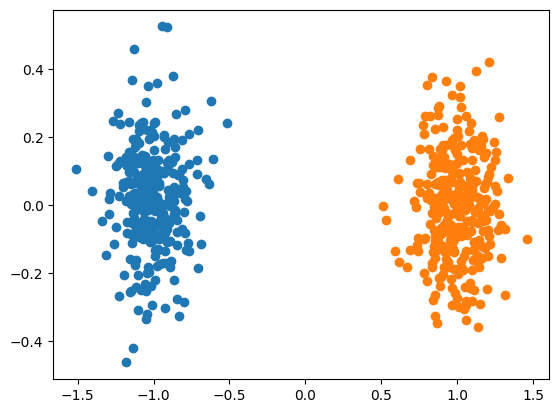

In [13]:
#blobs?

num_classes = 2

X, Y = blobs(num_samples=600, n_blobs = num_classes)
plot_clusters(X, Y)

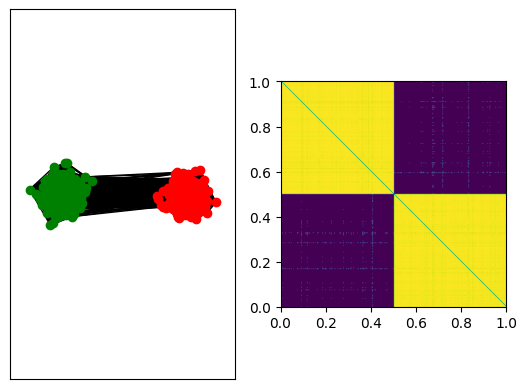

In [14]:
W = build_similarity_graph(X, var = 3, eps = 0.7)
plot_graph_matrix(X, Y, W)  # shows the graph and the visualization of W

The spectral clustering algorithm is a nonsupervised learning method so it relies on user input to perform well. We recall that the multiplicity of the 0 eigenvalue of the Laplacian corresponds to the number of connected components in the graph, given that we have a connected graph this is not important information. What we need is to look at the other eigenvalues (the ones just greater than 0) and we also look at the $k$ first eigenvectors (after $\mathbb{1}_n$) when wanting to cluster $k$ clusters. Here $k=2$ so we look at the eigenvector 1 and 2. Since here we have no constraint we can just consider "trying" to solve min cut problem so we take the unnormalized Laplacian.

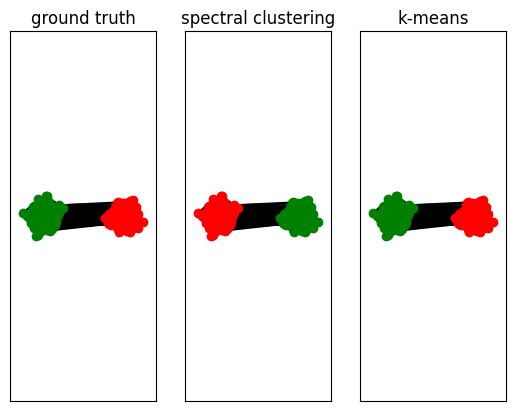

In [15]:
L = build_laplacian(W, 'unn')
Y_rec, w = spectral_clustering(L, chosen_eig_indices=[1, 2], num_classes=num_classes)
# Plot results, comparing to KMeans
plot_clustering_result(X, Y, W, Y_rec, KMeans(num_classes, n_init=10).fit_predict(X))

We have obtained the same clustering as k-means in this situation, it seems that building a graph and using spectral clustering is not necessary since the classes are linearly seperable.

### Q2.2: Build a graph starting from the data generated in `blobs`, but this time make it so that the two components are separated. How do you choose which eigenvectors to use in this case? Motivate your answer.

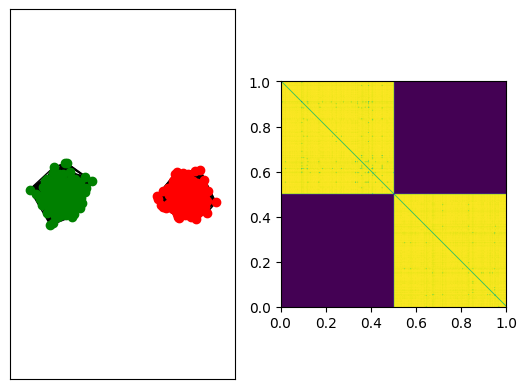

In [16]:
W = build_similarity_graph(X, var = 3, eps = 0.9)
plot_graph_matrix(X, Y, W)  # shows the graph and the visualization of W

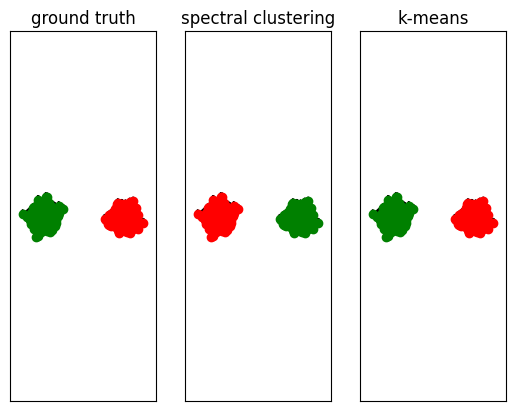

In [17]:
L = build_laplacian(W, 'sym')
Y_rec,w = spectral_clustering(L, chosen_eig_indices=[0], num_classes=num_classes)

#print(Y_rec)
# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes, n_init=10).fit_predict(X))

In the case where we have a disconnected graph we know that the connected components correspond to the clusters. Since there are 2 connected components the eigenvalue 0 has multiplicity 2 with associated eigenvectors $\mathbb{1}_{C_1}$ and $\mathbb{1}_{C_2}$. This means there is a binary representation of the nodes, either it is in $C_1$ and its value (in the projected space when choosing $\mathbb{1}_{C_1}$) is $>0$ or it is in $C_2$ and it's value is $0$ we then use k-Means in this new space (here a simple logical rule would suffise to cluster). 

### Q2.3: In the function spectral_clustering, implement an automatic strategy to choose the eigenvectors to use for clustering, when chosen_eig_indices=None. Explain your strategy. Generate a dataset with 4 blobs and test your function. What happens when the variance of the blobs increase?

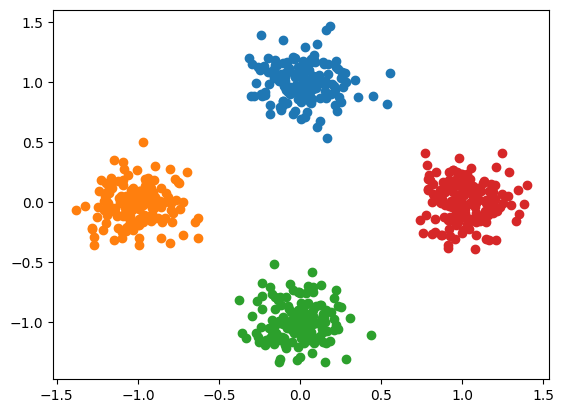

In [18]:
X, Y = blobs(num_samples=600, n_blobs=4, blob_var=0.15)
plot_clusters(X, Y)

I'm thinking of 2 strategies to automatically choose the eigenvectors, and that is choosing the number of eigenvectors to pick. The first method consists of choosing the $k$ first eigenvectors (excluding $\mathbb{1}_n$) where $k$ is the number of clusters we want to make. The other method is to look at the magnitude of the eigenvalues and pick the eigenvectors that seem close to the first ones (the smoothest ones) and stop when there is a jump in magnitude. The first method is usefull when we know how many clusters we want to make, the second is best when we have no idea of how many clusters to make (it will choose a number of clusters depending on the number of eigenvectors it chooses). We recall that we use this method with a fully connected graph meaning that the constant eigenvector does not give any information on the clusters.

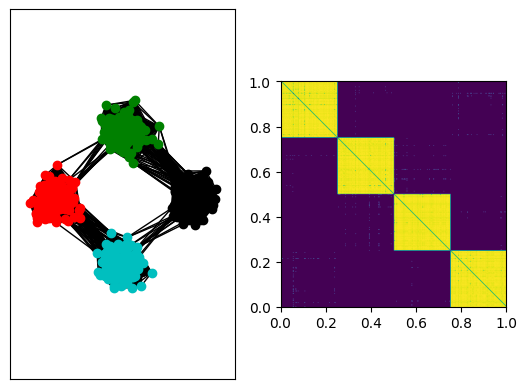

(600, 4)
4 eigenvectors were chosen


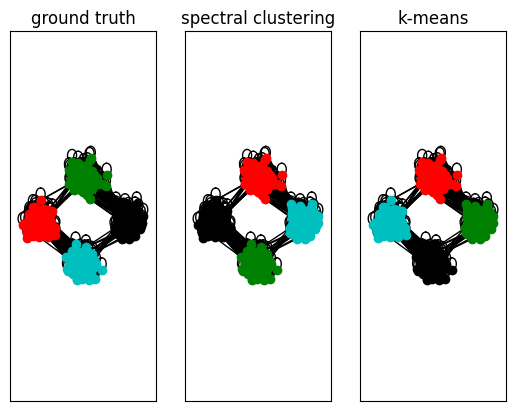

In [19]:
num_classes = 4

W = build_similarity_graph(X, var = 2, eps = 0.85)
plot_graph_matrix(X, Y, W)  # shows the graph and the visualization of W

L = build_laplacian(W, 'unn')
Y_rec,w = spectral_clustering(L, chosen_eig_indices=None, num_classes=4)

#print(Y_rec)
# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes, n_init=10).fit_predict(X))

Automatically picking the smallest eigenvalues that are not constant works well in this case. Let's try to add variance and see what happens.

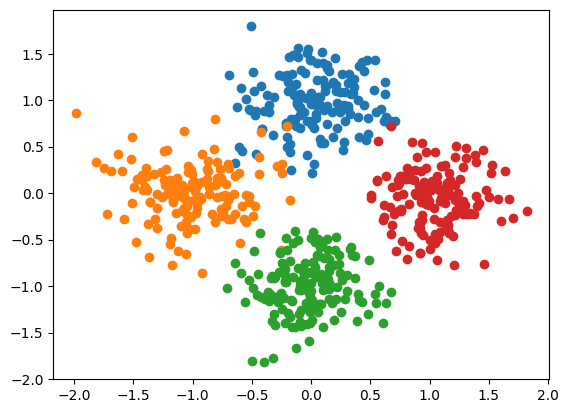

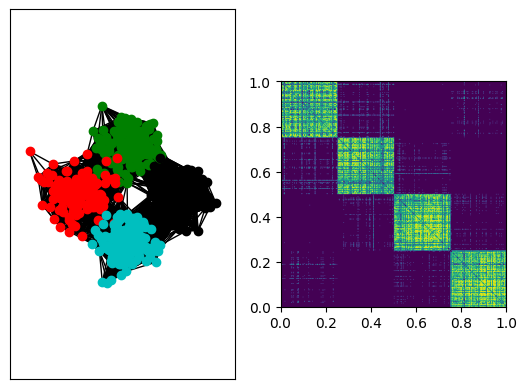

(600, 4)
4 eigenvectors were chosen


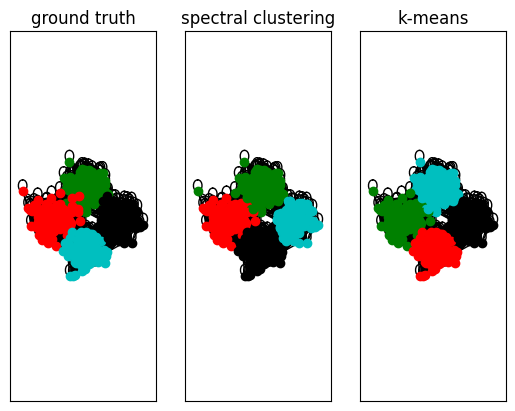

In [65]:
X, Y = blobs(num_samples=600, n_blobs=4, blob_var=0.3)
plot_clusters(X, Y)

num_classes = 4

W = build_similarity_graph(X, var = 1, eps = 0.8)
plot_graph_matrix(X, Y, W)  # shows the graph and the visualization of W

L = build_laplacian(W, 'unn')
Y_rec,w = spectral_clustering(L, chosen_eig_indices=None, num_classes=4)

#print(Y_rec)
# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes, n_init=10).fit_predict(X))

Here we still have satisfying results (similar to kmeans) let's add even more variance.

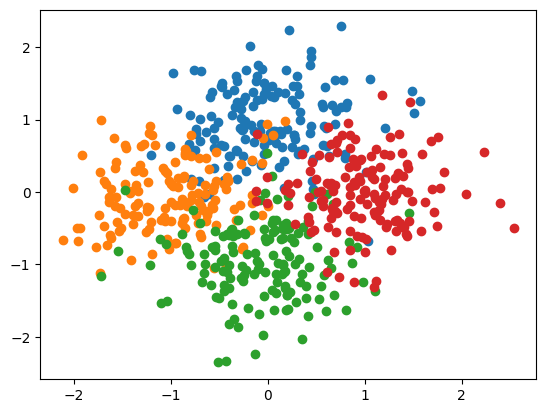

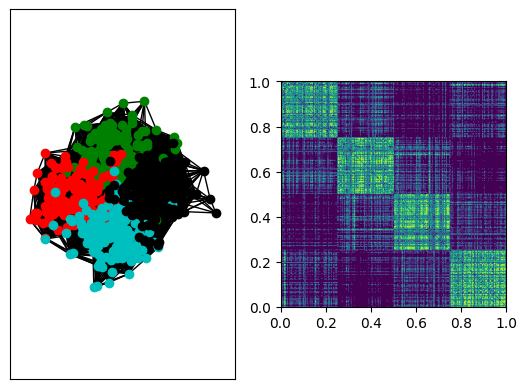

(600, 4)
4 eigenvectors were chosen


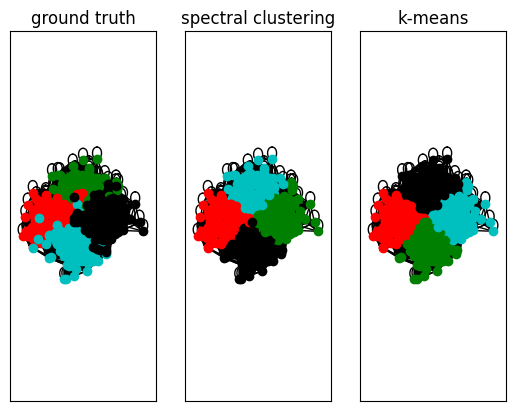

In [21]:
X, Y = blobs(num_samples=600, n_blobs=4, blob_var=0.5)
plot_clusters(X, Y)

num_classes = 4

W = build_similarity_graph(X, var = 2, eps = 0.8)
plot_graph_matrix(X, Y, W)  # shows the graph and the visualization of W

L = build_laplacian(W, 'sym')
Y_rec,w = spectral_clustering(L, chosen_eig_indices=None, num_classes=4)

#print(Y_rec)
# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes, n_init=10).fit_predict(X))

This time the "unn" Laplacian doesn't work so we've chosen for the symetric normalization which again splits in 4 groups of similar size but is close to k-means and less to the ground truth.

### Q2.4: When you built the cluster assignment, did you use thresholding, k-means or both? Do you have any opinion on when to use each?

I have only been using k-means since we don't have a clear representation of the data that can be thresholded. I believe that thresholding is used when we have a disconnected graph and that the constant by cluster eigenvalues are used. We then can threshold the value of the projected node to know in which connected component it is. We have seen this in the 2-blobs situation where when we have a disconnected graph we can look at eigenvector 0 and threshold.

### Q2.5: Generate `two_moons` data and compare spectral clustering to k-means. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

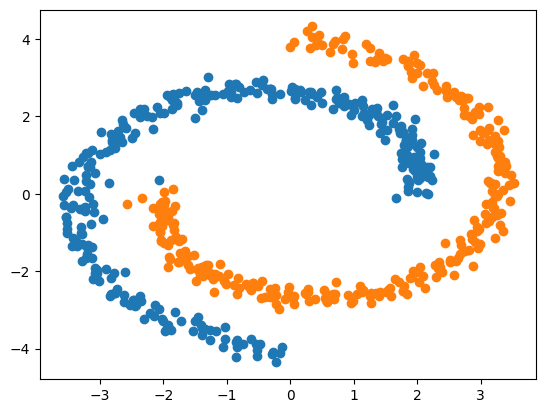

Signature: two_moons(num_samples, moon_radius=2.0, moon_var=0.02)
Docstring:
Creates two intertwined moons

:param num_samples: number of samples to create in the dataset
:param moon_radius: radius of the moons
:param moon_var:    variance of the moons
:return: X,  (num_samples, 2) matrix of 2-dimensional samples
         Y,  (num_samples, ) vector of "true" cluster assignment
File:      ~/Desktop/Cours/MVA/S2/GraphML/TP/spectral_clustering/generate_data.py
Type:      function

In [22]:
two_moons?
X, Y = two_moons(num_samples=600)
plot_clusters(X, Y)

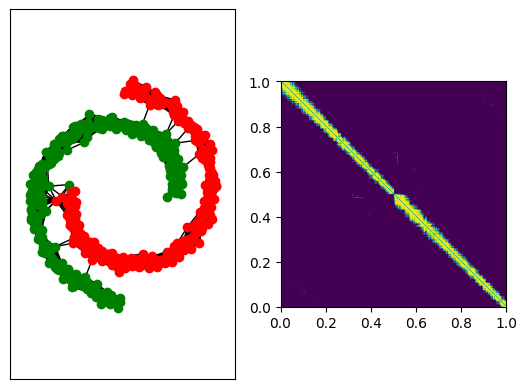

In [23]:
W = build_similarity_graph(X, var = 3, eps = 0.9)
plot_graph_matrix(X, Y, W)  # shows the graph and the visualization of W

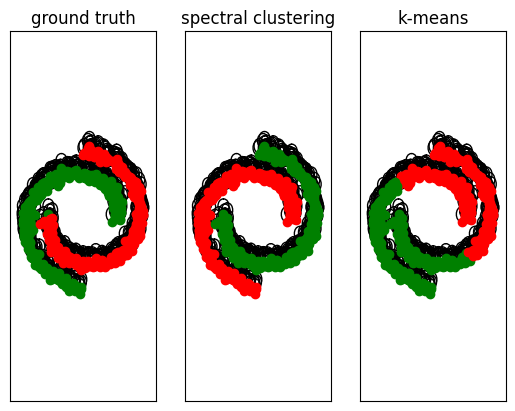

In [24]:
num_classes = 2 

L = build_laplacian(W, 'unn')
Y_rec,w = spectral_clustering(L, chosen_eig_indices=[1,2], num_classes=num_classes)

#print(Y_rec)
# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes, n_init=10).fit_predict(X))

K-means creates clusters of points in dense regions so the 2 moons dataset is not adapted since the high density areas mix the 2 clusters. With spectral clustering we build a graph of similarities that consider node by node similarity, when walking along a "moon" the data is more close / similar then when jumping to the other moon, so the graph structure understands this intertwining of data. We thus represent the data in another space (given by the first eigenvectors) that seperates better the moons and then we use k-means for better clustering results.

### Q2.6: Generate `point_and_circle` data and compare spectral clustering using the normal Laplacian and the random-walk regularized Laplacian. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

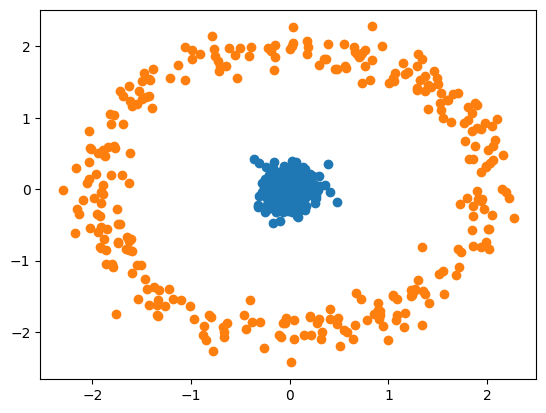

Signature: point_and_circle(num_samples, radius=2.0, sigma=0.15)
Docstring:
Creates point and circle

:param num_samples: number of samples to create in the dataset
:param sigma:       variance
:param radius:      radius of the circle
:return: X,  (num_samples, 2) matrix of 2-dimensional samples
         Y,  (num_samples, ) vector of "true" cluster assignment in {0, ..., c-1}
File:      ~/Desktop/Cours/MVA/S2/GraphML/TP/spectral_clustering/generate_data.py
Type:      function

In [25]:
point_and_circle?
X, Y = point_and_circle(num_samples=600)
plot_clusters(X, Y)

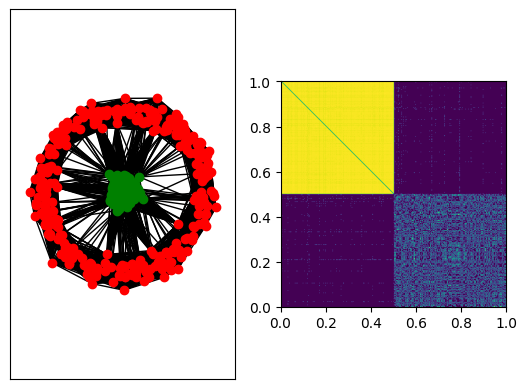

In [26]:
W = build_similarity_graph(X, var = 3, eps = 0.7)
plot_graph_matrix(X, Y, W)  # shows the graph and the visualization of W

random walk


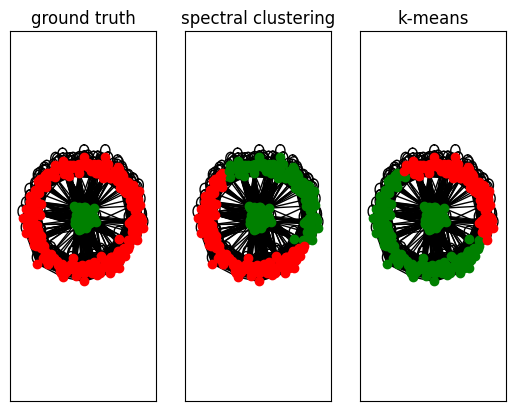

unnormalized


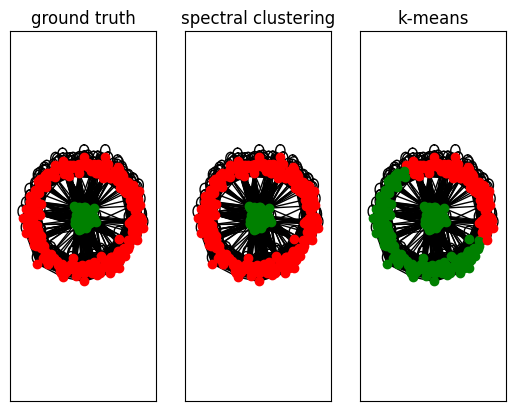

In [27]:
L1 = build_laplacian(W, 'rw')
L2 = build_laplacian(W, 'unn')
Y_rec1,w1 = spectral_clustering(L1, chosen_eig_indices=[1,2], num_classes=num_classes)
Y_rec2,w2 = spectral_clustering(L2, chosen_eig_indices=[1,2], num_classes=num_classes)

#print(Y_rec)
# Plot results, comparing to KMeans
print("random walk")
plot_clustering_result(X, Y, L1, Y_rec1, KMeans(num_classes, n_init=10).fit_predict(X))
print("unnormalized")
plot_clustering_result(X, Y, L2, Y_rec2, KMeans(num_classes, n_init=10).fit_predict(X))


The random-walk seems to perform less in this kind of data set, since data is not intertwined but just seperated by a margin, the unnormalized Laplacian is sufficient. Indeed the random-walk "allows" to jump from one area to another while still assigning these areas to the same cluster. Random-walk will be usefull in another example in the image clustering section but here is not needed. 

We recall that the graph is the same but the Laplacian changes the random-walk Laplacian contains information on the probability of passing from a node to another while being in the same area in the new projected space (and thus being clusterd together).

## Parameter sensitivity 

### Q2.7: Using the function parameter_sensitivity, comment on the stability of spectral clustering when varying $\epsilon$ or k. 

In [28]:
def parameter_sensitivity(parameter_type = "k", parameter_candidate = [1,2,3], laplacian_normalization = 'unn'):
    """
    TO BE COMPLETED.

    A function to test spectral clustering sensitivity to parameter choice.
    """
    # the number of samples to generate
    num_samples = 500

    """
    Choose parameters
    """
    var = 2.0  # exponential_euclidean's sigma^2
    
    chosen_eig_indices = [1, 2] #two clusters so we take two eigenvectors

    """
    Choose candidate parameters
    """
      # the number of neighbours for the graph (if 'k')
                                  # or the epsilon threshold (if 'eps')
    parameter_performance = []

    for parameter in parameter_candidate:
        # Generate data
        X, Y = two_moons(num_samples, 1, 0.02)
        num_classes = len(np.unique(Y))
        
        parameter_wrap = {parameter_type: parameter}
        
        W = build_similarity_graph(X, **parameter_wrap)
        L = build_laplacian(W, laplacian_normalization)

        Y_rec, w = spectral_clustering(L, chosen_eig_indices, num_classes)

        parameter_performance += [skm.adjusted_rand_score(Y, Y_rec)]

    plt.figure()
    plt.plot(parameter_candidate, parameter_performance)
    plt.title(f'parameter sensitivity ({parameter_type})')
    plt.show()

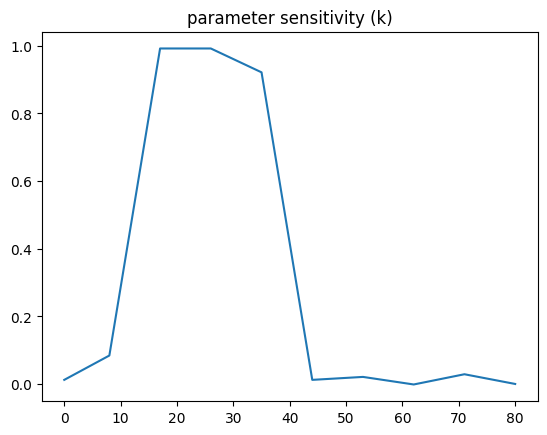

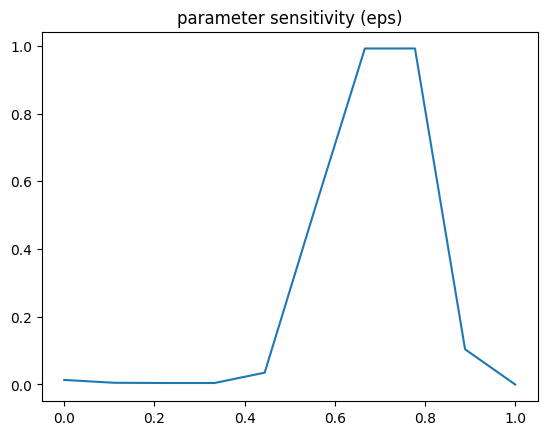

In [29]:
parameter_sensitivity(parameter_type = "k", parameter_candidate = np.linspace(0,80,10).astype(int), laplacian_normalization = 'unn')
parameter_sensitivity(parameter_type = "eps", parameter_candidate = np.linspace(0,1,10), laplacian_normalization = 'unn')

We are plotting an accuracy score of obtaining the correct clustering depending on the parameters of the similarity matrix. We see that picking the right parameters is crutial for solving spectral clustering problems, there is a big "spike" of performance when in the correct region for the parameter. This holds for $\epsilon$-graphs and $k$-nn graphs. For the current dataset it seems that choosing $\epsilon \in [0.6, 0.8]$ is a good idea for an $\epsilon$-graph or  $k \in [15,30]$ for a $k$-nn graph.

### Q2.8: If we did not have access to "true" labels, how could we evaluate the clustering result (or what should we not use as evaluation)?

Not knowing the true labels we can first think of what problem we are trying to solve and prior decisions we made. In the case of spectral clustering we want to solve the min cut problem that is intractable (or NP-hard) in general so we relax the problem such that our method of looking at the Laplacian eigenvectors approximates a solution to this problem. So first we can just evaluate the objectif function of the min cut which is minimizing the weights of the edges that pass from one cluster to another, with an assumption that the classes are balanced.

For other Laplacian (random-walk or symmetric) we are actually solving other cut problems which are the RatioCut and NCut, again we can check the value of these objectif functions with different runs of the clustering algorithm with different parameters.

In other cases if the data is visualizable in a space that keeps the data's structure and clustering information we can look with our eyes at how well the clustering was performed. We must still be carefull of linear projection methods that sometimes lose information and are not well suited for some dataset such as datasets living on manifolds.

That said there exists metrics that allow to evaluate this, we can check at how similar a point is to its cluster and to the rest for example the silhouette score allows to evaluate how well a clustering is done by returning the mean of the Silhouette coefficients that correspond to calculating the mean intra-cluster distance and the mean nearest-cluster for each sample and applying an formula that gives the wanted value. In this metric the best value is 1 and the worst value is -1 wher values near 0 indicate overlapping clusters. Check out : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html for more information.

## Image segmentation

### Q3.1: Complete all the code necessary, and cluster the `four_elements` and `fruit_salad` images in the data folder and include here some images of the clustering.  Explain your design choices in the overall pipeline (e.g. which graph, which pre-processing...) and how you think they impact the results you are seeing. Report also at least one failure mode for the algorithm.

In [85]:
from sklearn.metrics import silhouette_score
from skimage import io, transform


def image_segmentation(input_img='four_elements.bmp', num_classes = None, min_tree = False, scale = 1, var = 1, k = 20):
    """
    TO BE COMPLETED

    Function to perform image segmentation.

    :param input_img: name of the image file in /data (e.g. 'four_elements.bmp' or 'fruit_salad.bmp')
    """
    filename = os.path.join('data', input_img)

    X = io.imread(filename)
    X = (X - np.min(X)) / (np.max(X) - np.min(X))

    print("Original image size : {}".format(X.shape))
    im_side1 = np.size(X, 0)
    im_side2 = np.size(X, 1)

    #Downsampling
    if scale != 1:
        im_side1 = int(im_side1 * scale)
        im_side2 = int(im_side2 * scale)
        X_down = transform.resize(X, (im_side1,im_side2), mode='constant', anti_aliasing=True)
        Xr = X_down.reshape(im_side1 * im_side2, 3) #this allows for non square images 
    else:
        Xr = X.reshape(im_side1 * im_side2, 3) #this allows for non square images 
    """
    Y_rec should contain an index from 0 to c-1 where c is the     
     number of segments you want to split the image into          
    """

    """
    Choose parameters
    """
    
    if input_img == 'four_elements.bmp':
        laplacian_normalization = 'unn'
        chosen_eig_indices = [1, 2, 3, 4, 5]
        num_classes = 5
    elif input_img == 'fruit_salad.bmp':
        laplacian_normalization = 'rw'
        chosen_eig_indices = [1, 2, 3, 4]
        num_classes = 4
    else :
        laplacian_normalization = 'unn'
        chosen_eig_indices = None #[1,2,3,4,5,6]
           
    W = build_similarity_graph(Xr, var=var, k= k)
    print("graph built")
    if min_tree:
        W = min_span_tree(W)
    L = build_laplacian(W, laplacian_normalization)
    print("laplacian computed")
    Y_rec, w = spectral_clustering(L, chosen_eig_indices, num_classes=num_classes)
    print("clustering done")

    
    Y_rec = Y_rec.reshape(im_side1, im_side2)
    if scale != 1:
        # Perform the rescaling with mean interpolation
        Y_rec = transform.resize(Y_rec, (X.shape[0], X.shape[1]), mode='constant', anti_aliasing=True)

    plt.figure()

    plt.subplot(1, 2, 1)
    plt.imshow(X)

    plt.subplot(1, 2, 2)
    plt.imshow(Y_rec)

    plt.show()
    plot_eig(w)

    #print("Silhouette score : {}".format(silhouette_score(X, Y_rec.flatten())))
    

Original image size : (50, 50, 3)
graph built
laplacian computed
clustering done


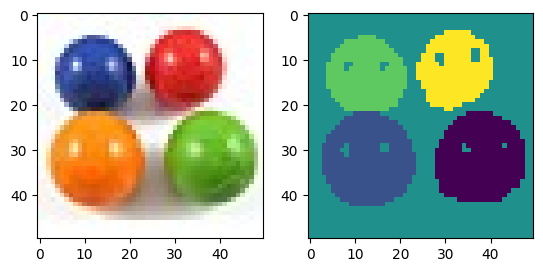

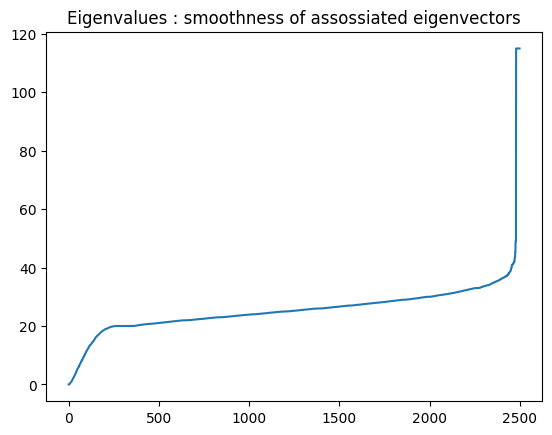

In [95]:
image_segmentation("four_elements.bmp")

Original image size : (50, 50, 3)
graph built
laplacian computed
clustering done


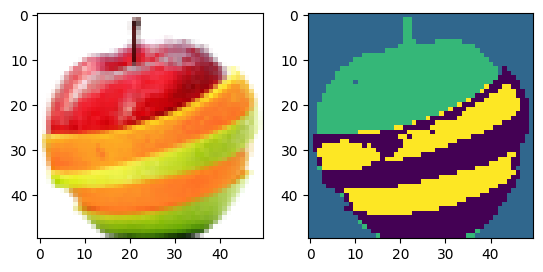

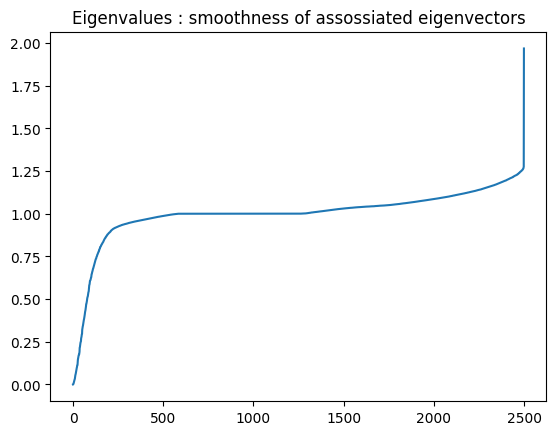

In [40]:
image_segmentation("fruit_salad.bmp")

First we have to build a graph, this corresponds to looking at each pixel which corresponds to a point in $\{0,...,255\}^3$ a subset of $\mathbb{R}^3$ so points of similar color will be "similar" and thus connected with an edge :
>I chose to build a $k-$nearest-neighbours graph with $k  = 20$ (this was chosen arbitrarily when trying the algorithm with satisfactory results) and a variance of 1.0 for the similarity matrix. 

Second we need to choose the parameters of our algorithm :

>We need to choose which type of Laplacian matrix normalisation we want. For `four_elements` since the balloons are not intertwined a simple unnormalized Laplacian seems to do the job. For `fruit_salad` I chose the random-walk Laplacian since the classes are intertwined, applying a random walk process to travel the graph is an interesting option. Indeed, we can construct a transition matrix containing the probabilities of passing from one node to another:  $P = D^{-1}W$. We then can define the random-walk Laplacian : $L_{rw} = I - P$. Looking at this when picking a small eigenvector (a smooth one) for the Laplacian, we actually pick a large eigenvector for the transition matrix. This thus gives us clustering information since we look at the "high frequencies" of the transition matrix's spectrum.

So $L_{four elements} = L_{unn}$ and $L_{fruit salad} = L_{rw}$.

>Looking at the images we know how many clusters we have to make : `four_elements` contains 4 colored balloons and the background so $\textbf{5 classes}$, `fruit_salad` contains a mixture of a red apple, an orange and a green apple, to that we add the background so $\textbf{4 classes}$.
>
>Looking at the smoothness graph (graph of increasing eigenvalues), we notice that there a lot of eigenvalues that are "stable" before a jump, this in practice makes us choose a lot of eigenvectors but doesn't work well since there are not as many clusters.

So we choose to set the `num_class` parameter to . 

> We then either choose manually the eigenvectors without knowing if they correspond to ones that are non constant (maybe here the knn graph is not connected so having the information of number of connected components can be interesting), or let the algorithm choose the eigenvectors. .

We thus choose the eigenvectors. For `four_elements` we choose the eigenvectors $\{u_1,u_2,u_3,u_4,u_5\}$ and for `fruit_salad` we go for $\{u_1,u_2,u_3,u_4\}$. 

As for the results, they seem satisfying even though some pixels are not well assigned (e.g. points of light on the objects are assigned to the background).

Another thing we can try is to evaluate this using the previous cited metric, the Silhouette score, since we don't have access to the ground truth (we could have done it by hand and built a mask but...). Looking at the scores we are better then 0 but not very close to 1. When trying out different parameters sometimes the Silhouette score is higher when I believe the segmentation is less good.


### Q3.2: A full graph built between the pixels of a 50 × 50 image corresponds to $50^2$ nodes. Solving the full eigenvalue problem in this case would scale in the order of $2^{34}$ . Even on weak hardware this takes only seconds to minutes. Segmenting a Full HD picture of 1920 × 1080 would scale in the order of $2^{64}$ (about a month on a decent machine). Beyond that, the large picture would require to store in memory a graph over millions of nodes. A full graph on that scale requires about 1TB of memory. Can you think two simple techniques to reduce the computational and occupational cost of Spectral Clustering?

The problem of occupational cost is that we cannot store each pixel in memory. So what we can do is down-sample by applying a down sampling technique such as assigning one node to a group of pixels that are close by maybe priotizing similarity in the color space or just take the mean color of the neighbours (different strategies exists for choosing the "neighborhoud").

For computational cost, a powerful property is sparcity, having a lot of zeros in the weight matrix meaning having few connections in the graph, this reduces a lot the number of computations during spectral clustering. We can for instance use min spanning trees that reduce drastically the mean degree of the graph (but this seems to make the Laplacian singular when wanting to work with different normalizations also I don't think it is a very good idea because the matrix is $\textbf{very}$ sparse so there is very few information in the Laplacian) or pick appropriate parameters ($k$ or $\epsilon$) to build a sparse graph.

Once we have applied the clustering we upsample the image to match the original resolution.

### Q3.3: Choose a larger image of your choice, and try to implement some of the scalability modifications to run spectral clustering on it. Report some examples of the results you achieve. 

The goal is to come back to images of around the same size as the 2 previous ones (ie $\approx 50\times50$), we will use an image of size $940 \times 1276$ so we downscale by $\frac{1}{20}$ with bi-linear interpolation (spline of order 1).
We will preserve the k-nn graph we've done for the other methods and we have tried out different normalizations results do not defer much, so going for "unn" has less computational cost (no inverse even though inverting a diagonal matrix is not complicated). 

Original image size : (940, 1276, 3)
graph built
laplacian computed
clustering done


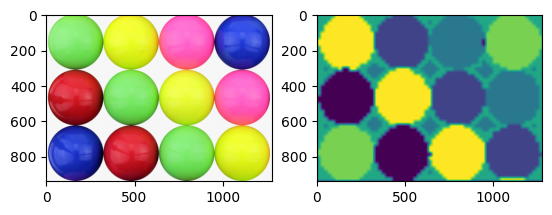

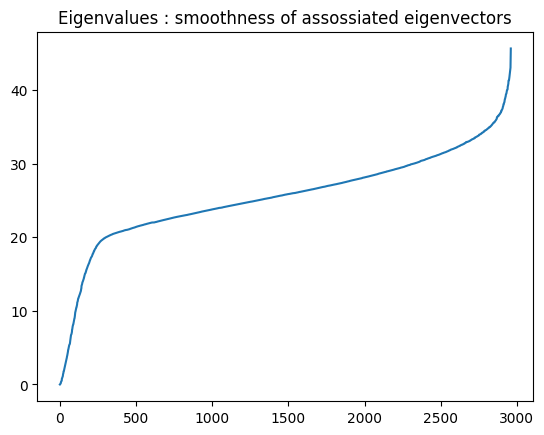

In [63]:
image_segmentation(input_img='hdImage.jpg', num_classes = 6, min_tree = False, scale = 0.05)

Result is satisfying even if points in the background are not well clustered. This is surely due to the downsampling loosing information on these thin areas, maybe problems with aliasing also appear even though we apply anti_alliasing.

Original image size : (750, 1000, 3)
graph built
laplacian computed
2 eigenvectors were chosen
clustering done


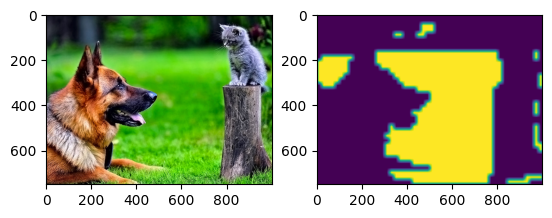

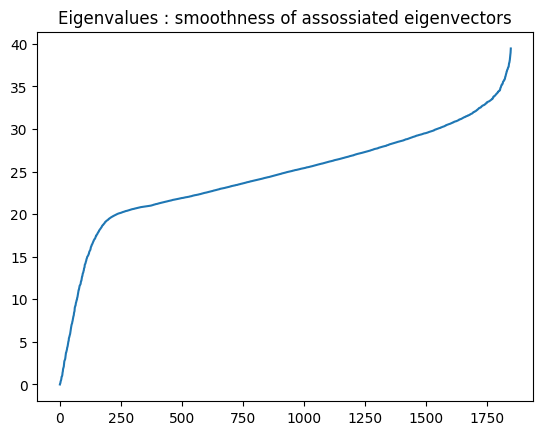

In [94]:
image_segmentation(input_img='cat-vs-dog.jpg', num_classes = 2, min_tree = False, scale = 0.05, var = 1.0, k = 20)

For this example it seems harder to find the right number of classes because a simple spectral clustering method like here doesn't seem to capture features in the way a CNN would. The automatic detection number of classes doesn't work well here it seems, so I believe that there are mainly 2 classes {animal, background}. Part of the background is clustered with the animals but it seems to be quite satisfying.